**First, installing necessary packages and libraries for pre-processing**

In [ ]:
install.packages(c("tidyverse", "e1071", "caret", "corrplot"))


# Load tidyverse
library(tidyverse)
library(e1071)
library(caret)
library(corrplot)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘sparsevctrs’, ‘timeDate’, ‘proxy’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: lattice


Attaching package: ‘caret’


The



```
# This is formatted as code
```

**Loading the data from Google Drive: Please ensure that the data is saved as BreastCancerData.csv in your Google Drive**

In [ ]:
# Mount Google Drive
library(googledrive)
library(readr)

drive_deauth()  # avoid auth issues in shared work
drive_auth()    # you may be prompted to grant access

# Make sure your csv file is exactly under the My Drive, not in any other subfolder!!!
# Use file picker (or set filename manually if known)
file <- drive_get("BreastCancerData.csv")  # change if your file name is different
drive_download(file, path = "BreastCancerData.csv", overwrite = TRUE)

# Read the downloaded file
data <- read_csv("BreastCancerData.csv")


Is it OK to cache OAuth access credentials in the folder ~/.cache/gargle
between R sessions?
1: Yes
2: No


Selection: 1


Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-frjlouoa3s2ono25d2l9ukvhlsrlnr7k.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=https%3A%2F%2Fwww.tidyverse.org%2Fgoogle-callback%2F&response_type=code&state=de47190517925ee233858deb5c094152&access_type=offline&prompt=consent



Enter authorization code: eyJjb2RlIjoiNC8wQWJfNXFsbjZnTHZKWEZDV3g1OGdIWHhETkRPSmk1OXF1ellLaGp6TVBrbndDZjNBUGs1cHVpd01sbjJGUlJ6b2ZwZmdSdyIsInN0YXRlIjoiZGU0NzE5MDUxNzkyNWVlMjMzODU4ZGViNWMwOTQxNTIifQ==


✔ The input `path` resolved to exactly 1 file.

File downloaded:

• BreastCancerData.csv <id: 1tBAQIN5-PJkiizdo8VOLe-44L8gTh2G6>

Saved locally as:

• BreastCancerData.csv

New names:
• `` -> `...33`
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 568 Columns: 33
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): diagnosis
dbl (31): id, radius_mean, texture_mean, perimeter_mean, area_mean, smoothne...
lgl  (1): ...33

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


**Overall view of the dataset**


In [ ]:
# Number of rows and columns
cat("Number of rows:", nrow(data), "\n")
cat("Number of columns:", ncol(data), "\n")

# Class distribution
cat("Diagnosis class distribution:\n")
print(table(data$diagnosis))

# Quick summary of all variables
cat("Summary of numeric features:\n")
print(summary(data %>% select(where(is.numeric))))

# Check column names
cat("Column names:\n")
print(colnames(data))


Number of rows: 568 
Number of columns: 33 
Diagnosis class distribution:

  B   M 
356 212 
Summary of numeric features:
       id             radius_mean      texture_mean   perimeter_mean  
 Min.   :     8670   Min.   : 6.981   Min.   : 9.71   Min.   : 43.79  
 1st Qu.:   869222   1st Qu.:11.707   1st Qu.:16.17   1st Qu.: 75.20  
 Median :   906157   Median :13.375   Median :18.84   Median : 86.29  
 Mean   : 30425140   Mean   :14.139   Mean   :19.28   Mean   : 92.05  
 3rd Qu.:  8825022   3rd Qu.:15.797   3rd Qu.:21.79   3rd Qu.:104.15  
 Max.   :911320502   Max.   :28.110   Max.   :39.28   Max.   :188.50  
   area_mean      smoothness_mean   compactness_mean  concavity_mean   
 Min.   : 143.5   Min.   :0.06251   Min.   :0.01938   Min.   :0.00000  
 1st Qu.: 420.3   1st Qu.:0.08640   1st Qu.:0.06517   1st Qu.:0.02958  
 Median : 551.4   Median :0.09589   Median :0.09312   Median :0.06155  
 Mean   : 655.7   Mean   :0.09644   Mean   :0.10445   Mean   :0.08896  
 3rd Qu.: 784.1   3rd

**The dataset initially includes an id column used solely for identification purposes and an unnamed column (...33) that contains only missing values. Since these features provide no informative value for classification, they will be removed.**

In [ ]:
# Drop unnecessary columns
data <- data %>% select(-id, -`...33`)

# Convert diagnosis to factor
data$diagnosis <- as.factor(data$diagnosis)

# Confirm structure
str(data)


tibble [568 × 31] (S3: tbl_df/tbl/data.frame)
 $ diagnosis              : Factor w/ 2 levels "B","M": 2 2 2 2 2 2 2 2 2 2 ...
 $ radius_mean            : num [1:568] 18 20.6 19.7 11.4 20.3 ...
 $ texture_mean           : num [1:568] 10.4 17.8 21.2 20.4 14.3 ...
 $ perimeter_mean         : num [1:568] 122.8 132.9 130 77.6 135.1 ...
 $ area_mean              : num [1:568] 1001 1326 1203 386 1297 ...
 $ smoothness_mean        : num [1:568] 0.1184 0.0847 0.1096 0.1425 0.1003 ...
 $ compactness_mean       : num [1:568] 0.2776 0.0786 0.1599 0.2839 0.1328 ...
 $ concavity_mean         : num [1:568] 0.3001 0.0869 0.1974 0.2414 0.198 ...
 $ concave points_mean    : num [1:568] 0.1471 0.0702 0.1279 0.1052 0.1043 ...
 $ symmetry_mean          : num [1:568] 0.242 0.181 0.207 0.26 0.181 ...
 $ fractal_dimension_mean : num [1:568] 0.0787 0.0567 0.06 0.0974 0.0588 ...
 $ radius_se              : num [1:568] 1.095 0.543 0.746 0.496 0.757 ...
 $ texture_se             : num [1:568] 0.905 0.734 0.787 1.

**Distribution of Target Variable, Diagnosis. B = Benign, M = Malignant**

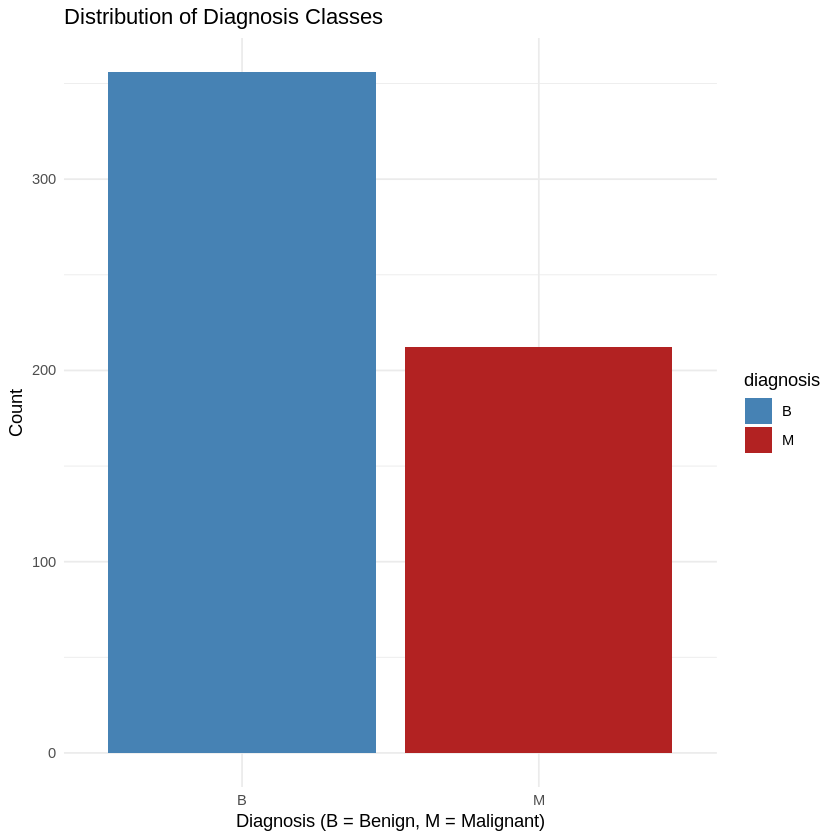

In [ ]:
ggplot(data, aes(x = diagnosis, fill = diagnosis)) +
  geom_bar() +
  scale_fill_manual(values = c("B" = "steelblue", "M" = "firebrick")) +
  labs(
    title = "Distribution of Diagnosis Classes",
    x = "Diagnosis (B = Benign, M = Malignant)",
    y = "Count"
  ) +
  theme_minimal()


**Checking for Skewness in Features**

In [ ]:
data_long <- data %>%
  pivot_longer(
    cols = -diagnosis,
    names_to = "Feature",
    values_to = "Value"
  )


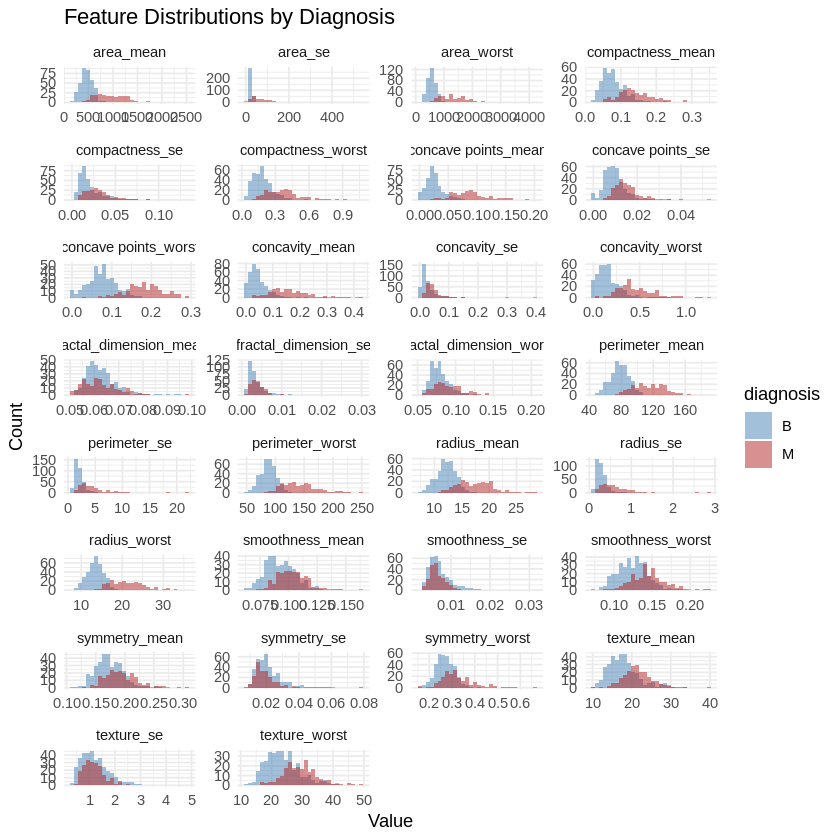

In [ ]:
#Plotting distributions of features
ggplot(data_long, aes(x = Value, fill = diagnosis)) +
  geom_histogram(position = "identity", alpha = 0.5, bins = 30) +
  facet_wrap(~ Feature, scales = "free", ncol = 4) +
  scale_fill_manual(values = c("B" = "steelblue", "M" = "firebrick")) +
  labs(
    title = "Feature Distributions by Diagnosis",
    x = "Value",
    y = "Count"
  ) +
  theme_minimal()


In [ ]:
# Remove the diagnosis column so we’re only checking numeric features
numeric_data <- data %>% select(-diagnosis)

# Calculate skewness for each feature
skew_values <- apply(numeric_data, 2, skewness)
skew_values_sorted <- sort(skew_values, decreasing = TRUE)

# Convert to data frame for better readability
skew_df <- data.frame(
  Feature = names(skew_values_sorted),
  Skewness = round(skew_values_sorted, 3)
)

# Print top 10 most skewed features nicely
head(skew_df, 10)


,Feature,Skewness
,<chr>,<dbl>
area_se,area_se,5.415
concavity_se,concavity_se,5.091
fractal_dimension_se,fractal_dimension_se,3.899
perimeter_se,perimeter_se,3.422
radius_se,radius_se,3.069
smoothness_se,smoothness_se,2.301
symmetry_se,symmetry_se,2.188
compactness_se,compactness_se,1.894
area_worst,area_worst,1.850


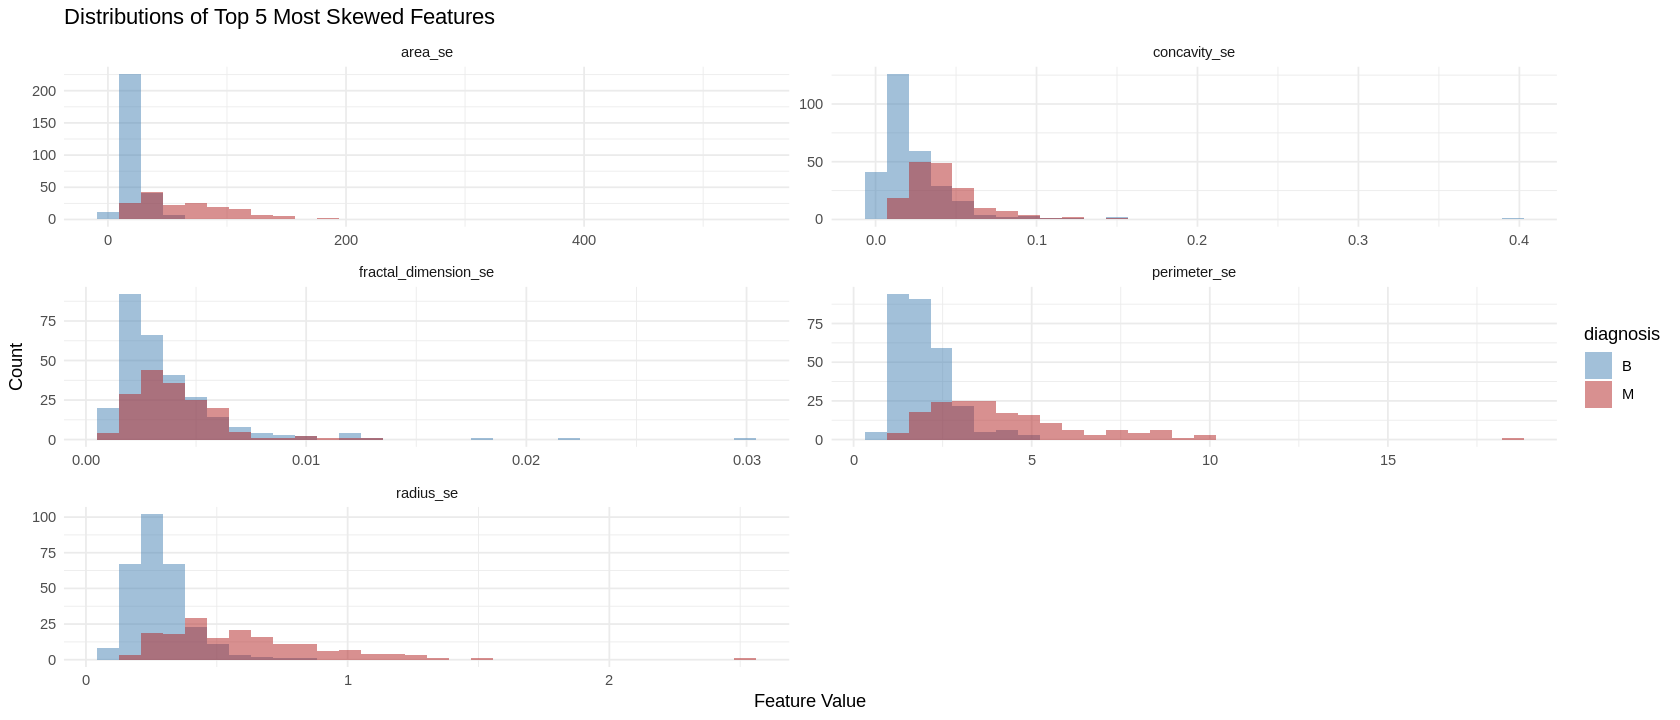

In [ ]:
# Define top 5 most skewed features
top_skewed_features <- c("area_se", "concavity_se", "fractal_dimension_se", "perimeter_se", "radius_se")

# Filter data_long to only include these features
top_skewed_data <- data_long %>%
  filter(Feature %in% top_skewed_features)

# Plot distributions
ggplot(top_skewed_data, aes(x = Value, fill = diagnosis)) +
  geom_histogram(position = "identity", alpha = 0.5, bins = 30) +
  facet_wrap(~ Feature, scales = "free", ncol = 2) +
  scale_fill_manual(values = c("B" = "steelblue", "M" = "firebrick")) +
  labs(
    title = "Distributions of Top 5 Most Skewed Features",
    x = "Feature Value",
    y = "Count"
  ) +
  theme_minimal()


**Checking for Missing Values**

In [ ]:
missing_values <- data.frame(
  Feature = colnames(data),
  Missing_Values = colSums(is.na(data))
)

print(missing_values)


                                        Feature Missing_Values
diagnosis                             diagnosis              0
radius_mean                         radius_mean              0
texture_mean                       texture_mean              0
perimeter_mean                   perimeter_mean              0
area_mean                             area_mean              0
smoothness_mean                 smoothness_mean              0
compactness_mean               compactness_mean              0
concavity_mean                   concavity_mean              0
concave points_mean         concave points_mean              0
symmetry_mean                     symmetry_mean              0
fractal_dimension_mean   fractal_dimension_mean              0
radius_se                             radius_se              0
texture_se                           texture_se              0
perimeter_se                       perimeter_se              0
area_se                                 area_se        

**Train/Test Split**

In [ ]:
# Split data into training and test set to prevent data leakage

# Set seed for reproducibility
set.seed(123)

# Create stratified indices
train_index <- createDataPartition(data$diagnosis, p = 0.8, list = FALSE)

# Split the data
train_data <- data[train_index, ]
test_data  <- data[-train_index, ]

# Check class balance
cat("Train set size:", nrow(train_data), "\n")
cat("Test set size:", nrow(test_data), "\n")
table(train_data$diagnosis)
table(test_data$diagnosis)

Train set size: 455 
Test set size: 113 



  B   M 
285 170 


 B  M 
71 42 

**Normalizing Features**

In [ ]:
# Create a pre-processing object (excluding the diagnosis column)
preproc <- preProcess(train_data %>% select(-diagnosis), method = c("center", "scale"))

# The test set is normalized using the training set's distribution
train_normalized <- train_data
train_normalized[, -which(names(train_normalized) == "diagnosis")] <- predict(preproc, train_data %>% select(-diagnosis))

test_normalized <- test_data
test_normalized[, -which(names(test_normalized) == "diagnosis")] <- predict(preproc, test_data %>% select(-diagnosis))

In [ ]:
data_long_norm <- train_normalized %>%
  pivot_longer(
    cols = -diagnosis,
    names_to = "Feature",
    values_to = "Value"
  )

head(data_long_norm, 10)


diagnosis,Feature,Value
<fct>,<chr>,<dbl>
M,radius_mean,1.123159
M,texture_mean,-2.101280
M,perimeter_mean,1.299388
M,area_mean,1.012273
M,smoothness_mean,1.583114
M,compactness_mean,3.287554
M,concavity_mean,2.735816
M,concave points_mean,2.626192
M,symmetry_mean,2.307242


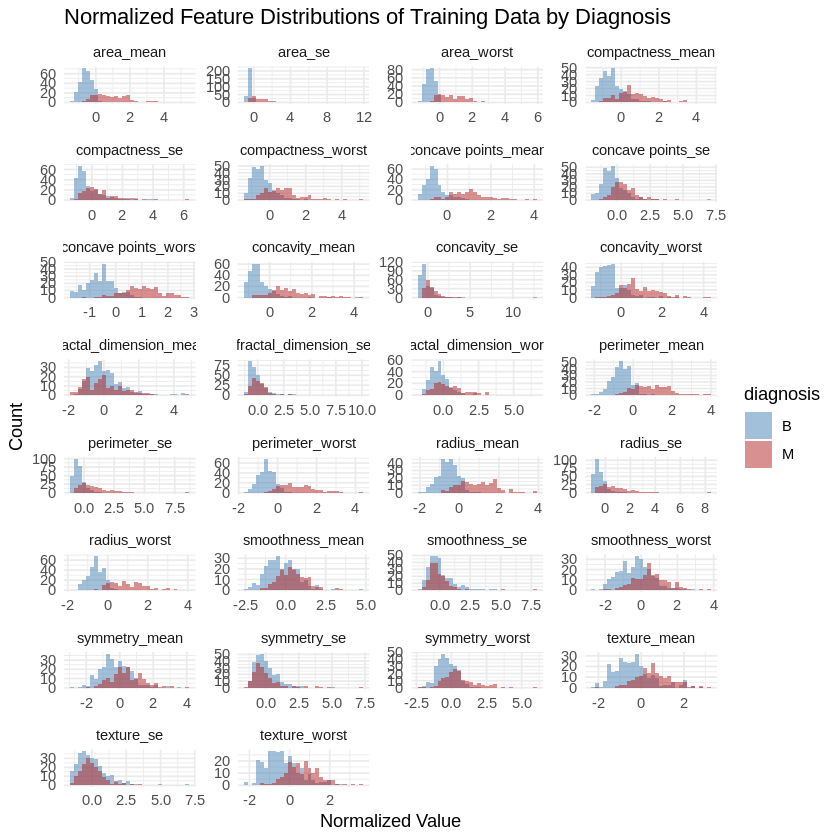

In [ ]:
#Plotting normalized feature distribution of training data
ggplot(data_long_norm, aes(x = Value, fill = diagnosis)) +
  geom_histogram(position = "identity", alpha = 0.5, bins = 30) +
  facet_wrap(~ Feature, scales = "free", ncol = 4) +
  scale_fill_manual(values = c("B" = "steelblue", "M" = "firebrick")) +
  labs(
    title = "Normalized Feature Distributions of Training Data by Diagnosis",
    x = "Normalized Value",
    y = "Count"
  ) +
  theme_minimal()


**Check for Multicollinearity - Correlation amongst features**

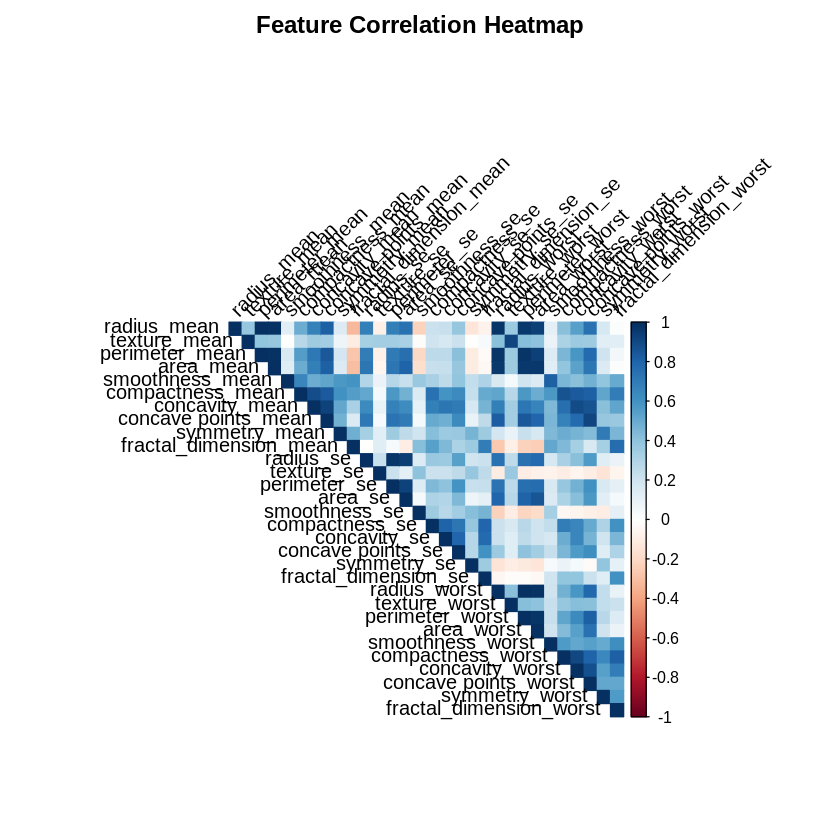

In [ ]:
# Drop the target variable (diagnosis) to focus on numeric features
numeric_data <- train_normalized %>% select(-diagnosis)

# Compute the correlation matrix
cor_matrix <- cor(numeric_data)

# Plot correlation heatmap
corrplot(cor_matrix,
         method = "color",
         type = "upper",
         tl.col = "black",
         tl.srt = 45,
         title = "Feature Correlation Heatmap",
         mar = c(0, 0, 2, 0))


**Features with correlation above 0.9. Optional to drop highly correlated features**

> Add blockquote



In [ ]:
# Use caret's findCorrelation to identify features with correlation > 0.9

high_corr <- findCorrelation(cor_matrix, cutoff = 0.9, names = TRUE, verbose = TRUE)

# Convert the correlation matrix into a tidy dataframe of pairs
cor_pairs <- as.data.frame(as.table(cor_matrix)) %>%
  filter(Var1 != Var2) %>%                             # exclude self-correlations
  mutate(abs_corr = abs(Freq)) %>%
  filter(abs_corr > 0.9) %>%                           # filter for strong correlations
  arrange(desc(abs_corr)) %>%
  distinct(pmin(Var1, Var2), pmax(Var1, Var2), .keep_all = TRUE) %>%  # remove duplicate pairs
  select(Feature_1 = Var1, Feature_2 = Var2, Correlation = Freq)

# Display result
print(cor_pairs)



Compare row 7  and column  8 with corr  0.924 
  Means:  0.578 vs 0.4 so flagging column 7 
Compare row 8  and column  28 with corr  0.913 
  Means:  0.55 vs 0.388 so flagging column 8 
Compare row 27  and column  26 with corr  0.9 
  Means:  0.501 vs 0.378 so flagging column 27 
Compare row 23  and column  21 with corr  0.994 
  Means:  0.485 vs 0.369 so flagging column 23 
Compare row 21  and column  3 with corr  0.97 
  Means:  0.451 vs 0.36 so flagging column 21 
Compare row 3  and column  24 with corr  0.94 
  Means:  0.418 vs 0.354 so flagging column 3 
Compare row 24  and column  1 with corr  0.94 
  Means:  0.393 vs 0.35 so flagging column 24 
Compare row 13  and column  11 with corr  0.974 
  Means:  0.403 vs 0.346 so flagging column 13 
Compare row 1  and column  4 with corr  0.988 
  Means:  0.337 vs 0.342 so flagging column 4 
Compare row 11  and column  14 with corr  0.945 
  Means:  0.336 vs 0.345 so flagging column 14 
Compare row 22  and column  2 with corr  0.915 
  Me

Warning message:
“There were 2 warnings in `distinct()`.
The first warning was:
ℹ In argument: `pmin(Var1, Var2)`.
Caused by warning in `Ops.factor()`:
! ‘>’ not meaningful for factors
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”


              Feature_1           Feature_2 Correlation
1        perimeter_mean         radius_mean   0.9977956
2           radius_mean      perimeter_mean   0.9977956
3       perimeter_worst        radius_worst   0.9935966
4          radius_worst     perimeter_worst   0.9935966
5             area_mean         radius_mean   0.9881673
6            area_worst        radius_worst   0.9834540
7          perimeter_se           radius_se   0.9736705
8             radius_se        perimeter_se   0.9736705
9               area_se           radius_se   0.9454907
10  concave points_mean      concavity_mean   0.9244871
11       concavity_mean concave points_mean   0.9244871
12        texture_worst        texture_mean   0.9145256
13         texture_mean       texture_worst   0.9145256
14 concave points_worst concave points_mean   0.9125729
15      concavity_worst   compactness_worst   0.9000360
16    compactness_worst     concavity_worst   0.9000360


In [ ]:
# Drop highly correlated features based on correlation pairs since SVM model is sensitive to multicollinearity
features_to_drop <- c(
  "perimeter_mean",
  "perimeter_worst",
  "area_mean",
  "area_worst",
  "perimeter_se",
  "area_se",
  "concave points_mean",
  "texture_mean"
)

train_normalized_reduced <- train_normalized %>% select(-all_of(features_to_drop))


[1] "\nFeature Importance Analysis:"
                                        Feature Correlation
concave points_worst       concave points_worst 0.789660917
radius_worst                       radius_worst 0.773790910
radius_mean                         radius_mean 0.730135496
concavity_mean                   concavity_mean 0.695051788
concavity_worst                 concavity_worst 0.685412207
compactness_worst             compactness_worst 0.598900611
radius_se                             radius_se 0.593868152
compactness_mean               compactness_mean 0.588553170
texture_worst                     texture_worst 0.497153274
symmetry_worst                   symmetry_worst 0.435934038
concave points_se             concave points_se 0.415053655
smoothness_worst               smoothness_worst 0.413107737
symmetry_mean                     symmetry_mean 0.339790809
fractal_dimension_worst fractal_dimension_worst 0.328966018
smoothness_mean                 smoothness_mean 0.322690052
com

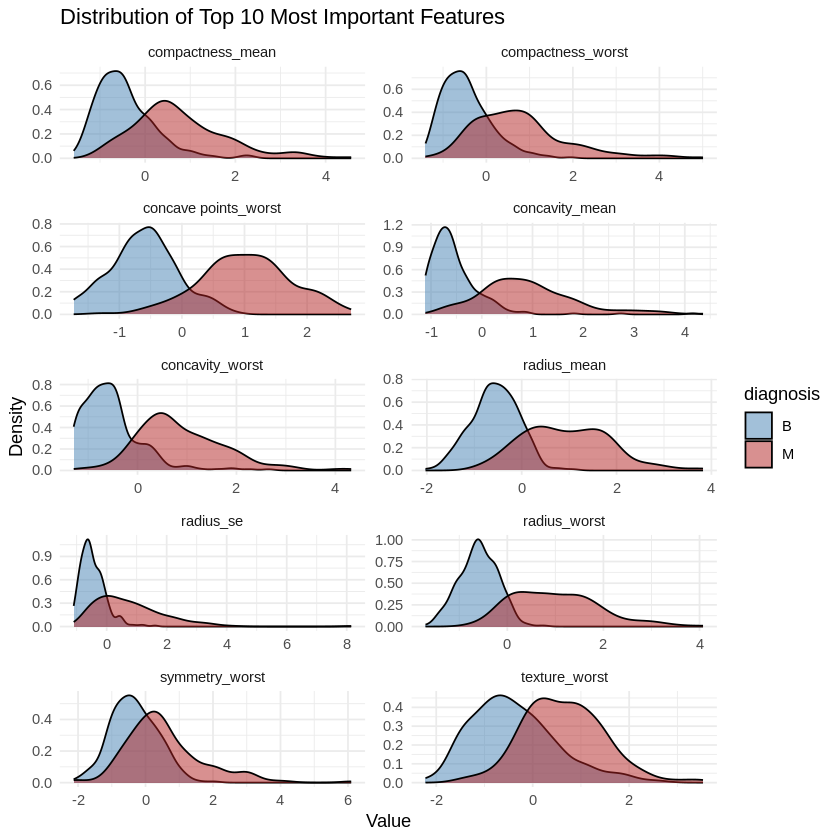

In [ ]:
# To understand feature importance

print("\nFeature Importance Analysis:")
diagnosis_numeric <- as.numeric(train_normalized_reduced$diagnosis) - 1  # Convert to 0/1
feature_importance <- data.frame(
  Feature = names(train_normalized_reduced)[-which(names(train_normalized_reduced) == "diagnosis")],
  Correlation = sapply(train_normalized_reduced[, -which(names(train_normalized_reduced) == "diagnosis")],
                      function(x) abs(cor(x, diagnosis_numeric)))
)

# Sort by absolute correlation
feature_importance <- feature_importance[order(-feature_importance$Correlation),]
print(feature_importance)

# Plot top 10 most important features
print("\nPlotting top 10 most important features...")
top_features <- head(feature_importance$Feature, 10)
data_long_top <- train_normalized_reduced %>%
  select(all_of(top_features), diagnosis) %>%
  pivot_longer(cols = -diagnosis, names_to = "Feature", values_to = "Value")

print(ggplot(data_long_top, aes(x = Value, fill = diagnosis)) +
  geom_density(alpha = 0.5) +
  facet_wrap(~ Feature, scales = "free", ncol = 2) +
  scale_fill_manual(values = c("B" = "steelblue", "M" = "firebrick")) +
  labs(
    title = "Distribution of Top 10 Most Important Features",
    x = "Value",
    y = "Density"
  ) +
  theme_minimal())


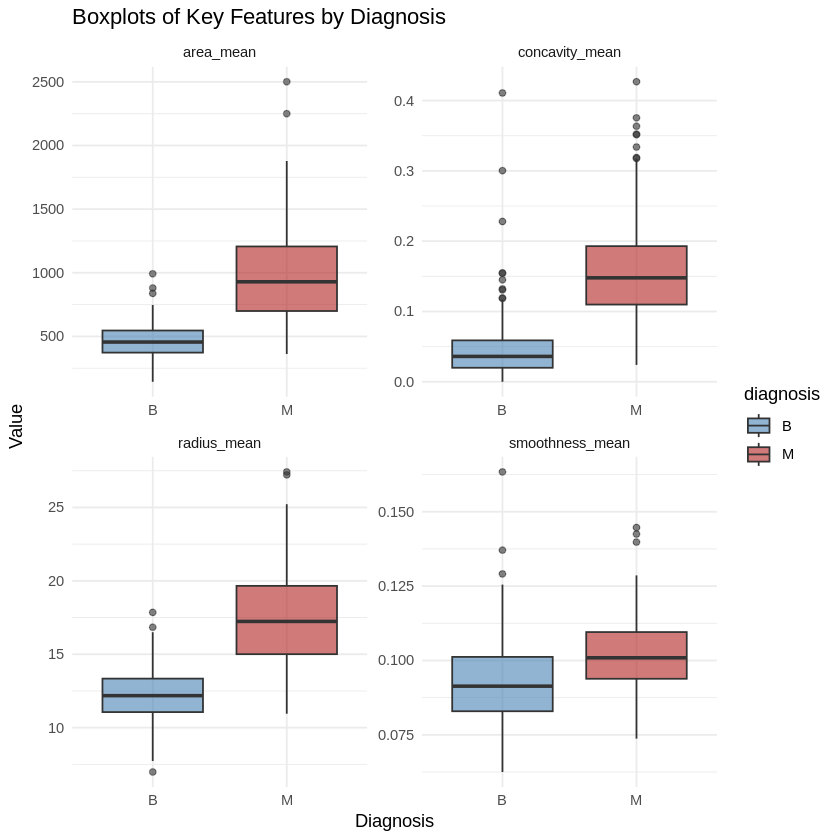

In [ ]:
# Reshape to long format for plotting
data_long <- train_data %>%
  pivot_longer(cols = -diagnosis, names_to = "Feature", values_to = "Value")

# Plot boxplots for selected features
ggplot(
  data_long %>% filter(Feature %in% c("radius_mean", "area_mean", "concavity_mean", "smoothness_mean")),
  aes(x = diagnosis, y = Value, fill = diagnosis)
) +
  geom_boxplot(alpha = 0.6) +
  facet_wrap(~ Feature, scales = "free", ncol = 2) +
  scale_fill_manual(values = c("B" = "steelblue", "M" = "firebrick")) +
  labs(
    title = "Boxplots of Key Features by Diagnosis",
    x = "Diagnosis",
    y = "Value"
  ) +
  theme_minimal()


Support Vector Machine

In [ ]:
install.packages("kernlab")
install.packages("themis")
install.packages("fpc")  # For silhouette plot
library(fpc)
install.packages("cluster")
library(cluster)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RANN’, ‘ROSE’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘modeltools’, ‘DEoptimR’, ‘mclust’, ‘flexmix’, ‘prabclus’, ‘diptest’, ‘robustbase’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# Load required packages
library(e1071)
library(caret)
library(pROC)
library(ggplot2)

print("Training model...")
model <- train(
  diagnosis ~ .,
  data = train_normalized_reduced,
  method = "svmRadial",
  metric = "ROC",
  preProcess = c("center", "scale"),
  trControl = trainControl(method = "cv", number = 5, classProbs = TRUE, summaryFunction = twoClassSummary),
  tuneGrid = data.frame(C = 1, sigma = 0.1)
)

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var




[1] "Training model..."


In [ ]:
# Evaluate on test set
print("Model Performance on Test Set:")
test_predictions <- predict(model, test_normalized[, -which(names(test_normalized) == "diagnosis")])
test_probs <- predict(model, test_normalized[, -which(names(test_normalized) == "diagnosis")], type = "prob")

# Calculate test performance metrics
test_cm <- confusionMatrix(test_predictions, test_normalized$diagnosis)
test_auc <- roc(test_normalized$diagnosis, test_probs[,2])$auc

# Print test performance
cat("\nTest Accuracy:", round(test_cm$overall['Accuracy'], 4))
cat("\nTest AUC:", round(test_auc, 4))
cat("\nTest Confusion Matrix:\n")
print(test_cm$table)


[1] "Model Performance on Test Set:"


Setting levels: control = B, case = M

Setting direction: controls < cases




Test Accuracy: 0.9558
Test AUC: 0.999
Test Confusion Matrix:
          Reference
Prediction  B  M
         B 66  0
         M  5 42


**Visualization techniques**

**1. ROC curve**

Setting levels: control = B, case = M

Setting direction: controls < cases



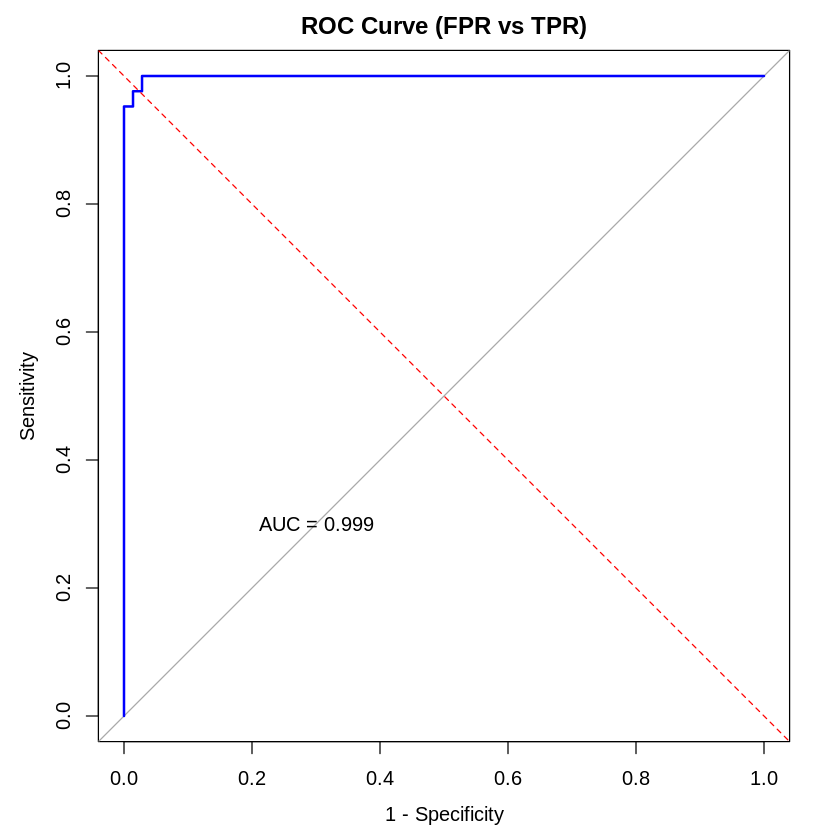

In [ ]:
# Plot ROC curve for test set
roc_curve <- roc(test_normalized$diagnosis, test_probs[,2])
plot(roc_curve, main = "ROC Curve (FPR vs TPR)", col = "blue", legacy.axes = TRUE)

abline(a = 0, b = 1, lty = 2, col = "red")
text(0.7, 0.3, paste("AUC =", round(test_auc, 4)))

**2. Silhouette plot**

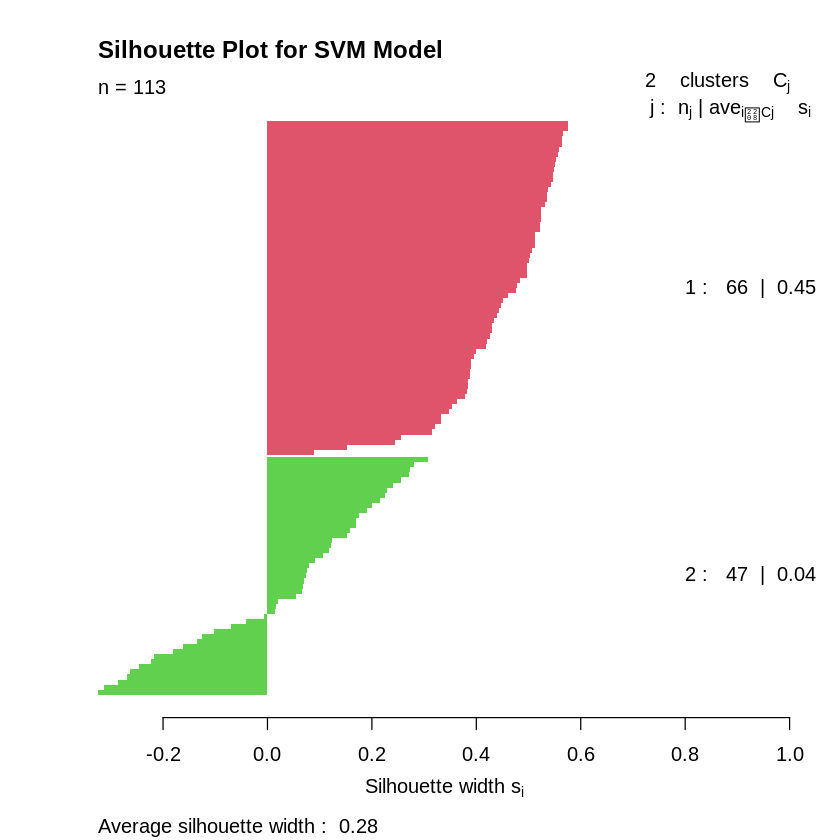

In [ ]:
# Get decision function for test set
svm_decision_scores <- predict(model, test_normalized[, -which(names(test_normalized) == "diagnosis")], type = "raw")
svm_decision_scores <- as.numeric(svm_decision_scores)

# Calculate Silhouette scores for test set
dist_matrix <- dist(test_normalized[, -which(names(test_normalized) == "diagnosis")])
sil_score <- silhouette(as.numeric(svm_decision_scores), dist_matrix)

# Plot the Silhouette plot
plot(sil_score, main = "Silhouette Plot for SVM Model", col = 2:3)



**3. Classmap**

[1] "\nCreating Classmap..."


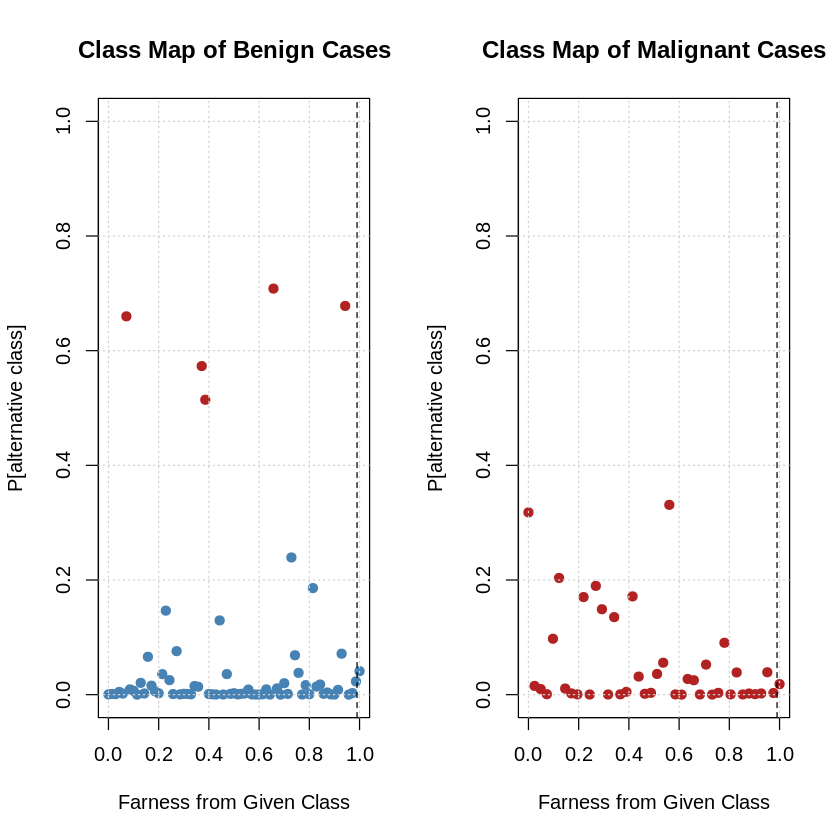

In [ ]:
print("\nCreating Classmap...")
# Get prediction probabilities
pred_probs <- predict(model, test_normalized[, -which(names(test_normalized) == "diagnosis")], type = "prob")

# Create separate data frames for each class
benign_data <- data.frame(
  prob = pred_probs[test_normalized$diagnosis == "B", "M"],
  fairness = seq(0, 1, length.out = sum(test_normalized$diagnosis == "B")),
  true_class = "B",
  predicted = test_predictions[test_normalized$diagnosis == "B"]
)

malignant_data <- data.frame(
  prob = pred_probs[test_normalized$diagnosis == "M", "B"],
  fairness = seq(0, 1, length.out = sum(test_normalized$diagnosis == "M")),
  true_class = "M",
  predicted = test_predictions[test_normalized$diagnosis == "M"]
)

# Plot classmaps
par(mfrow = c(1, 2))

# Plot for Benign cases
plot(benign_data$fairness, benign_data$prob,
     col = ifelse(benign_data$predicted == "B", "steelblue", "firebrick"),
     pch = 19,
     main = "Class Map of Benign Cases",
     xlab = "Farness from Given Class",
     ylab = "P[alternative class]",
     ylim = c(0, 1))
abline(v = 0.99, lty = 2)
grid()

# Plot for Malignant cases
plot(malignant_data$fairness, malignant_data$prob,
     col = ifelse(malignant_data$predicted == "M", "firebrick", "steelblue"),
     pch = 19,
     main = "Class Map of Malignant Cases",
     xlab = "Farness from Given Class",
     ylab = "P[alternative class]",
     ylim = c(0, 1))
abline(v = 0.99, lty = 2)
grid()

**4. Stacked plot**

[1] "\nCreating Stackedplot..."


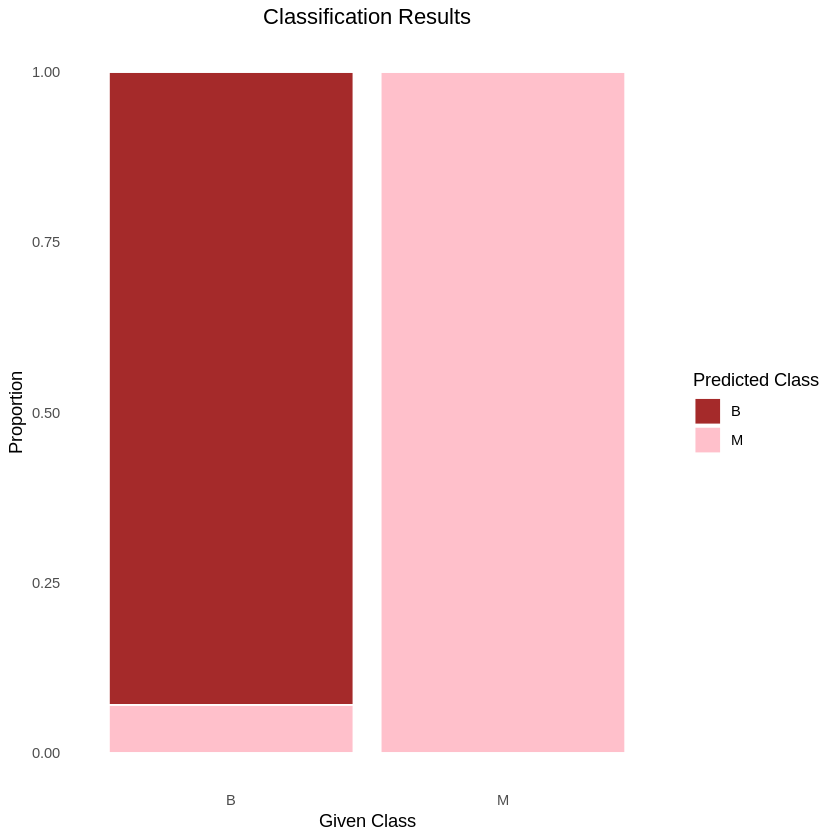

In [ ]:
print("\nCreating Stackedplot...")
# Calculate confusion matrix proportions
cm <- confusionMatrix(test_predictions, test_normalized$diagnosis)
cm_table <- cm$table
cm_props <- prop.table(cm_table, margin = 2)  # Calculate proportions by column (given class)

# Create data frame for plotting
plot_data <- data.frame(
  given_class = rep(colnames(cm_table), each = nrow(cm_table)),
  predicted_class = rep(rownames(cm_table), times = ncol(cm_table)),
  proportion = as.vector(cm_props)
)

# Plot stacked bar plot
print(ggplot(plot_data, aes(x = given_class, y = proportion, fill = predicted_class)) +
  geom_bar(stat = "identity", position = "stack", color = "white", linewidth = 0.5) +
  scale_fill_manual(values = c("B" = "brown", "M" = "pink")) +
  labs(
    title = "Classification Results",
    x = "Given Class",
    y = "Proportion",
    fill = "Predicted Class"
  ) +
  theme_minimal() +
  theme(
    panel.grid = element_blank(),
    axis.text.x = element_text(angle = 0, hjust = 0.5),
    plot.title = element_text(hjust = 0.5)
  ))


**5. Quasi Residual Plot**

In [ ]:
install.packages("patchwork")  # only once
library(patchwork)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_smooth()`).”
`geom_smooth()` using formula = 'y ~ x'


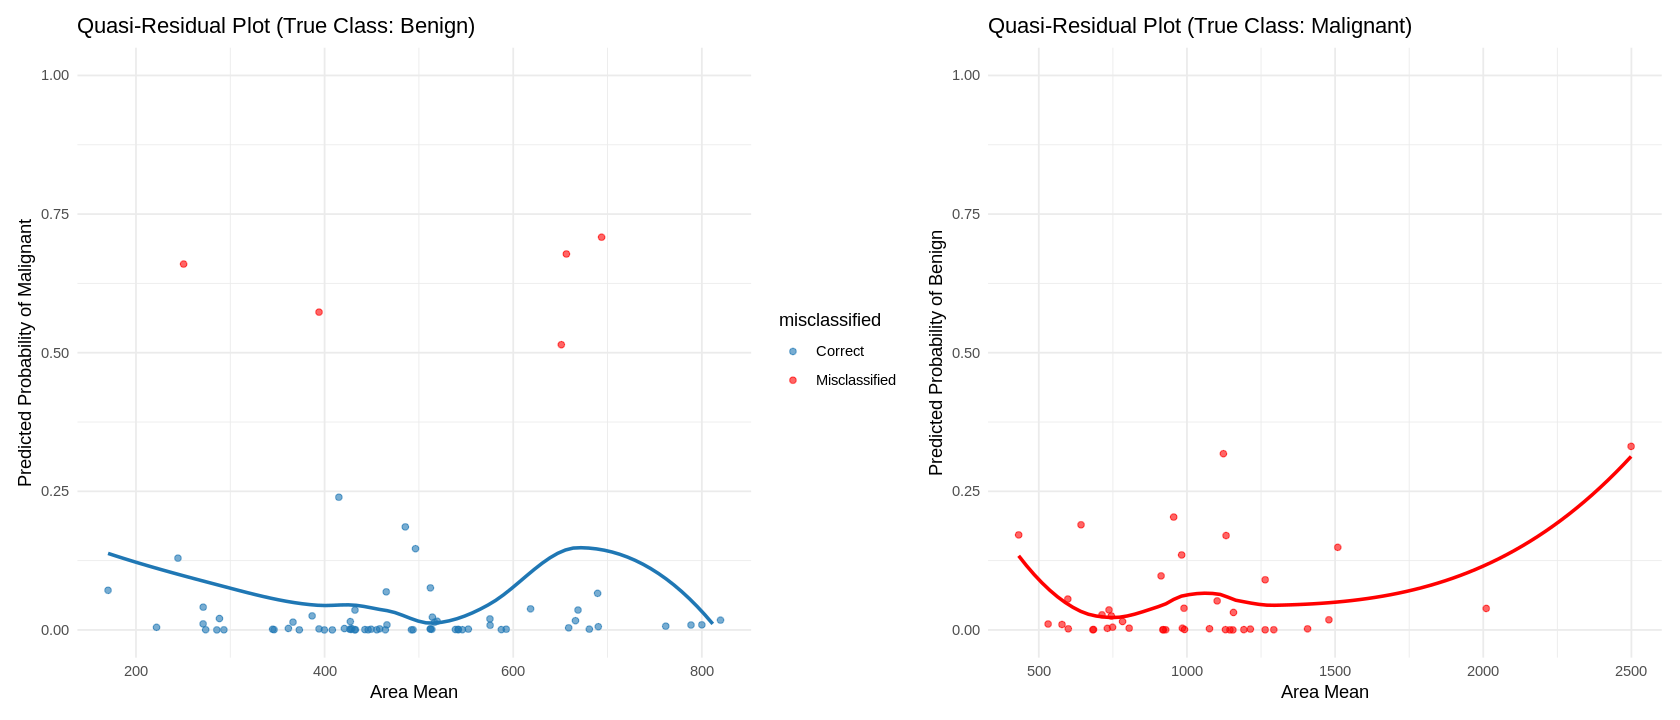

In [ ]:
# Add predicted probabilities and actual class to test data
plot_data <- test_data  # Use original test data (non-normalized)
plot_data$prob_malignant <- test_probs$M  # Predicted probability of malignant
plot_data$prob_benign <- test_probs$B    # Predicted probability of benign
plot_data$actual_class <- test_data$diagnosis
plot_data$area_mean <- test_data$area_mean  # Use the original 'area_mean' column

# Identify misclassified points: Benign points with high probability of Malignant
plot_data$misclassified <- ifelse(plot_data$actual_class == "B" & plot_data$prob_malignant > 0.5, "Misclassified", "Correct")

# Filter by actual class
benign_data <- plot_data[plot_data$actual_class == "B", ]
malignant_data <- plot_data[plot_data$actual_class == "M", ]

# Create individual plots
plot_benign <- ggplot(benign_data, aes(x = area_mean, y = prob_malignant, color = misclassified)) +
  geom_point(alpha = 0.6) +
  geom_smooth(method = "loess", color = "#1f77b4", se = FALSE) +  # Change line color to red
  scale_color_manual(values = c("Correct" = "#1f77b4", "Misclassified" = "#ff0000")) +  # Misclassified points in red
  labs(
    title = "Quasi-Residual Plot (True Class: Benign)",
    x = "Area Mean",
    y = "Predicted Probability of Malignant"
  ) +
  ylim(0, 1) +
  theme_minimal()

plot_malignant <- ggplot(malignant_data, aes(x = area_mean, y = prob_benign)) +  # Use prob_benign for the malignant plot
  geom_point(alpha = 0.6, color = "#ff0000") +  # Malignant points in red
  geom_smooth(method = "loess", color = "#ff0000", se = FALSE) +  # Change line color to red
  labs(
    title = "Quasi-Residual Plot (True Class: Malignant)",
    x = "Area Mean",
    y = "Predicted Probability of Benign"  # Changed label to match the new probability being plotted
  ) +
  ylim(0, 1) +
  theme_minimal()

# Set larger default plot size
options(repr.plot.width = 14, repr.plot.height = 6)  # Only needed in notebooks or inline display environments

# Show the side-by-side plots
plot_benign + plot_malignant
